In [1]:
%run supervised_functions.ipynb

# Generate data

In [2]:
start_mols = pickle.load(open("datasets/my_uspto/unique_start_mols.pickle", 'rb'))

In [3]:
np.random.seed(42)

N = 100000
steps = 5

df_list = []
final_shape = 0
smiles_per_random_sample = 1000
pool_chunk_size = 10

# Create dataset for multi-step pred
with Pool(30) as p, tqdm.tqdm(total=N) as pbar:
    while final_shape < N:
        smiles = np.random.choice(start_mols, size=(smiles_per_random_sample,))

        for new_df in p.imap_unordered(functools.partial(generate_train_data, steps=steps), smiles, chunksize=10):
            df_list.append(new_df)
            final_shape += new_df.shape[0]
            
        pbar.update(final_shape - pbar.n)

main_df = pd.concat(df_list)
del df_list
print(main_df.shape)

# randomize
main_df = pd.concat([main_df[:int(main_df.shape[0]*0.8)].sample(frac=1), main_df[int(main_df.shape[0]*0.8):].sample(frac=1)])
print(main_df.shape)

108127it [01:58, 911.68it/s]                                                                         


(108127, 10)
(108127, 10)


# Load/build stuff

In [4]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

#### Action embedings

In [5]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

action_rsigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["rsig"])))
action_psigs = data.Molecule.pack(list(map(molecule_from_smile, action_dataset["psig"])))

(89384, 8)


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ge`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Na`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ti`
  warnings.warn("Unknown value `%s`" % x)
/home/abhor/miniconda3/envs/de_

#### Indices (for faster access)

In [6]:
# I'm storing as lists, so doing numpy operations for the elements
correct_applicable_indices = []
correct_action_dataset_indices = []
action_embedding_indices = []

# for indices_used_for_data, correct_idx in tqdm.tqdm(map(get_emb_indices_and_correct_idx, main_df.iterrows()), total=main_df.shape[0]):
with Pool(20) as p:
    for indices_used_for_data, correct_app_idx, correct_act_idx in tqdm.tqdm(p.imap(get_emb_indices_and_correct_idx, main_df.iterrows(), chunksize=50), total=main_df.shape[0]):
        action_embedding_indices.append(indices_used_for_data)
        correct_applicable_indices.append(correct_app_idx)
        correct_action_dataset_indices.append(correct_act_idx)

100%|███████████████████████████████████████████████████████| 108127/108127 [04:59<00:00, 360.62it/s]


# Training

In [7]:
train_idx = np.arange(0, int(main_df.shape[0]*0.8))
test_idx = np.arange(int(main_df.shape[0]*0.8), main_df.shape[0])

train_idx = torch.arange(0, int(main_df.shape[0]*0.8))[:500]
test_idx = torch.arange(int(main_df.shape[0]*0.8), main_df.shape[0])[-200:]

In [8]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)
train_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["rsig"]))).to(device)
train_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["psig"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)
test_rsigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["rsig"]))).to(device)
test_psigs = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["psig"]))).to(device)

print(train_reactants.batch_size, train_products.batch_size, train_rsigs.batch_size, train_psigs.batch_size)
print(test_reactants.batch_size, test_products.batch_size, test_rsigs.batch_size, test_psigs.batch_size)

86501 86501 86501 86501
21626 21626 21626 21626
CPU times: user 13min 4s, sys: 36.4 s, total: 13min 40s
Wall time: 12min 57s


100%|████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.84it/s]


Epoch 1/50. Batch 86272/86373. Actor loss = 11.221589 || critic loss = 0.033163

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  1 │ 4.21483 │  0.799633 │         107.384 │         285.25 │        334.876 │         104.373 │        280.609 │        334.876 │ 11.80 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.05it/s]


BEST MODEL UPDATED! BEST RANK = 107.38411458333333
Epoch 2/50. Batch 86272/86373. Actor loss = 11.273687 || critic loss = 0.024551

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  2 │ 4.26932 │  0.817552 │         113.831 │        295.804 │        334.876 │         108.412 │        291.758 │        334.876 │ 11.54 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.56it/s]


Epoch 3/50. Batch 86272/86373. Actor loss = 11.250498 || critic loss = 0.025210

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  3 │ 4.23384 │  0.817759 │         113.513 │        294.563 │        334.876 │         106.491 │        288.692 │        334.876 │ 11.48 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.56it/s]


Epoch 4/50. Batch 86272/86373. Actor loss = 11.222691 || critic loss = 0.026479

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  4 │ 4.14546 │  0.813795 │         113.553 │        297.101 │        334.876 │         104.461 │          287.6 │        334.876 │ 11.59 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.00it/s]


Epoch 5/50. Batch 86272/86373. Actor loss = 11.126577 || critic loss = 0.026314

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  5 │ 4.09189 │  0.810704 │         110.614 │        289.678 │        334.876 │         101.122 │        278.538 │        334.876 │ 11.61 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.40it/s]


Epoch 6/50. Batch 86272/86373. Actor loss = 11.140732 || critic loss = 0.025827

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  6 │ 4.0735 │  0.806472 │         105.676 │        284.501 │        334.876 │         96.7806 │        273.652 │        334.876 │ 11.61 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧═

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.40it/s]


BEST MODEL UPDATED! BEST RANK = 105.6762927827381
Epoch 7/50. Batch 86272/86373. Actor loss = 11.167878 || critic loss = 0.028061

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  7 │ 4.01219 │   0.80382 │         104.386 │        285.313 │        334.876 │         96.6816 │          276.5 │        334.876 │ 11.48 min               │
╘════╧═════════╧═══════════╧════════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.75it/s]


BEST MODEL UPDATED! BEST RANK = 104.38588169642857
Epoch 8/50. Batch 86272/86373. Actor loss = 11.188482 || critic loss = 0.024683

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  8 │ 3.94095 │  0.800193 │         102.756 │        281.232 │        334.876 │         94.6148 │        271.922 │        334.876 │ 11.51 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.47it/s]


BEST MODEL UPDATED! BEST RANK = 102.75558035714286
Epoch 9/50. Batch 86272/86373. Actor loss = 11.198535 || critic loss = 0.026826

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│  9 │ 3.89926 │  0.798887 │         99.8103 │         275.07 │        334.876 │         92.2965 │         265.53 │        334.876 │ 11.41 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.52it/s]


BEST MODEL UPDATED! BEST RANK = 99.81026785714286
Epoch 10/50. Batch 86272/86373. Actor loss = 11.219784 || critic loss = 0.028237

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 10 │ 3.85255 │  0.796917 │         100.009 │        275.723 │        334.876 │          93.073 │        266.995 │        334.876 │ 11.44 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.88it/s]


Epoch 11/50. Batch 86272/86373. Actor loss = 11.255659 || critic loss = 0.025294

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 11 │ 3.82805 │  0.794051 │         97.3052 │        271.938 │        334.876 │         90.2082 │        262.376 │        334.876 │ 11.57 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.49it/s]


BEST MODEL UPDATED! BEST RANK = 97.3051990327381
Epoch 12/50. Batch 86272/86373. Actor loss = 11.147487 || critic loss = 0.026619

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 12 │ 3.76021 │  0.795145 │         94.3872 │        268.842 │        334.876 │         88.0044 │        260.648 │        334.876 │ 11.60 min               │
╘════╧═════════╧═══════════╧════════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.64it/s]


BEST MODEL UPDATED! BEST RANK = 94.3871837797619
Epoch 13/50. Batch 86272/86373. Actor loss = 11.231111 || critic loss = 0.024978

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 13 │ 3.77347 │  0.790742 │         95.7756 │         277.78 │        334.876 │         89.1518 │        267.235 │        334.876 │ 11.43 min               │
╘════╧═════════╧═══════════╧════════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.99it/s]


Epoch 14/50. Batch 86272/86373. Actor loss = 11.292830 || critic loss = 0.022630

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 14 │ 3.71346 │  0.790923 │         93.5849 │         274.08 │        334.876 │         86.9509 │        261.892 │        334.876 │ 11.37 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.15it/s]


BEST MODEL UPDATED! BEST RANK = 93.58491443452381
Epoch 15/50. Batch 86272/86373. Actor loss = 11.302098 || critic loss = 0.026768

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 15 │ 3.68826 │  0.789194 │         95.9522 │        277.965 │        334.876 │         89.4935 │        265.903 │        334.876 │ 11.35 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.25it/s]


Epoch 16/50. Batch 86272/86373. Actor loss = 11.337897 || critic loss = 0.022533

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 16 │ 3.63192 │  0.787231 │         93.4647 │        274.198 │        334.876 │         87.0475 │        262.761 │        334.876 │ 11.38 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.20it/s]


BEST MODEL UPDATED! BEST RANK = 93.46470424107143
Epoch 17/50. Batch 86272/86373. Actor loss = 11.286507 || critic loss = 0.023577

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 17 │ 3.6134 │  0.787992 │         92.7367 │        273.075 │        334.876 │         86.5166 │        261.661 │        334.876 │ 11.48 min               │
╘════╧════════╧═══════════╧═════════════════╧══

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.32it/s]


BEST MODEL UPDATED! BEST RANK = 92.73665364583333
Epoch 18/50. Batch 86272/86373. Actor loss = 11.349442 || critic loss = 0.025279

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 18 │ 3.61662 │  0.788439 │         92.2817 │        269.904 │        334.876 │         86.4781 │        259.587 │        334.876 │ 11.50 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.57it/s]


BEST MODEL UPDATED! BEST RANK = 92.2817150297619
Epoch 19/50. Batch 86272/86373. Actor loss = 11.323412 || critic loss = 0.021380

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 19 │ 3.62146 │  0.786655 │         91.5994 │        271.068 │        334.876 │         86.0087 │        260.891 │        334.876 │ 11.40 min               │
╘════╧═════════╧═══════════╧════════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.16it/s]


BEST MODEL UPDATED! BEST RANK = 91.59942336309524
Epoch 20/50. Batch 86272/86373. Actor loss = 11.283167 || critic loss = 0.021388

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 20 │ 3.59963 │  0.784924 │         92.2733 │        271.234 │        334.876 │         86.4033 │        261.332 │        334.876 │ 11.45 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.64it/s]


Epoch 21/50. Batch 86272/86373. Actor loss = 11.302158 || critic loss = 0.018055

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 21 │ 3.56934 │  0.784407 │         93.4573 │        272.403 │        334.876 │         87.9401 │        263.833 │        334.876 │ 11.44 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  8.92it/s]


Epoch 22/50. Batch 86272/86373. Actor loss = 11.346972 || critic loss = 0.020672

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 22 │ 3.55915 │  0.782264 │         92.0221 │        271.941 │        334.876 │         86.0294 │        261.587 │        334.876 │ 11.31 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:07<00:00,  5.98it/s]


Epoch 23/50. Batch 86272/86373. Actor loss = 11.350452 || critic loss = 0.021367

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 23 │ 3.50245 │  0.784977 │          91.125 │        268.805 │        334.876 │         85.7453 │         259.76 │        334.876 │ 11.45 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.73it/s]


BEST MODEL UPDATED! BEST RANK = 91.12495349702381
Epoch 24/50. Batch 86272/86373. Actor loss = 11.367537 || critic loss = 0.020593

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 24 │ 3.54236 │  0.782152 │         89.8276 │        265.339 │        334.876 │          84.585 │        256.986 │        334.876 │ 11.55 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.46it/s]


BEST MODEL UPDATED! BEST RANK = 89.8276134672619
Epoch 25/50. Batch 86272/86373. Actor loss = 11.371993 || critic loss = 0.015923

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 25 │ 3.51811 │  0.781427 │         88.9552 │        261.645 │        334.876 │         83.6647 │        254.373 │        334.876 │ 11.51 min               │
╘════╧═════════╧═══════════╧════════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.70it/s]


BEST MODEL UPDATED! BEST RANK = 88.95521763392857
Epoch 26/50. Batch 86272/86373. Actor loss = 11.384708 || critic loss = 0.016279

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 26 │ 3.51228 │  0.781364 │         92.0491 │        270.218 │        334.876 │         86.5613 │         262.88 │        334.876 │ 11.43 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.52it/s]


Epoch 27/50. Batch 86272/86373. Actor loss = 11.387444 || critic loss = 0.015769

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 27 │ 3.50142 │  0.779378 │         91.0568 │        267.035 │        334.876 │         84.9015 │        256.944 │        334.876 │ 11.35 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.60it/s]


Epoch 28/50. Batch 86272/86373. Actor loss = 11.560390 || critic loss = 0.017242

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 28 │ 3.46057 │  0.781277 │         90.9184 │        269.219 │        334.876 │          85.847 │        261.993 │        334.876 │ 11.37 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.34it/s]


Epoch 29/50. Batch 86272/86373. Actor loss = 11.428547 || critic loss = 0.018916

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 29 │ 3.45736 │  0.780267 │         92.4556 │        273.406 │        334.876 │         86.6185 │        263.267 │        334.876 │ 11.47 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.60it/s]


Epoch 30/50. Batch 86272/86373. Actor loss = 11.489470 || critic loss = 0.016899

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 30 │ 3.45557 │  0.781202 │         90.8373 │        269.844 │        334.876 │         85.2898 │        261.689 │        334.876 │ 11.52 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  7.84it/s]


Epoch 31/50. Batch 86272/86373. Actor loss = 11.529991 || critic loss = 0.013798

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 31 │ 3.4234 │  0.781374 │         91.4961 │        270.634 │        334.876 │         85.7232 │        263.107 │        334.876 │ 11.46 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.40it/s]


Epoch 32/50. Batch 86272/86373. Actor loss = 11.498567 || critic loss = 0.015485

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 32 │ 3.42907 │  0.780918 │         91.6689 │        272.593 │        334.876 │         86.2798 │         263.64 │        334.876 │ 11.42 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.50it/s]


Epoch 33/50. Batch 86272/86373. Actor loss = 11.597747 || critic loss = 0.014257

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 33 │ 3.41078 │   0.78231 │         91.1764 │        270.005 │        334.876 │         85.0934 │        260.399 │        334.876 │ 11.42 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.35it/s]


Epoch 34/50. Batch 86272/86373. Actor loss = 11.666242 || critic loss = 0.017212

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 34 │ 3.4006 │  0.781673 │         89.9405 │        270.164 │        334.876 │         83.7704 │        259.992 │        334.876 │ 11.29 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.15it/s]


Epoch 35/50. Batch 86272/86373. Actor loss = 11.521488 || critic loss = 0.016596

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 35 │ 3.39438 │  0.782718 │         89.8169 │        267.995 │        334.876 │          84.843 │        262.036 │        334.876 │ 11.42 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.63it/s]


Epoch 36/50. Batch 86272/86373. Actor loss = 11.644358 || critic loss = 0.015605

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 36 │ 3.41553 │  0.781416 │          89.485 │        269.147 │        334.876 │         84.1698 │        261.063 │        334.876 │ 11.46 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.64it/s]


Epoch 37/50. Batch 86272/86373. Actor loss = 11.604424 || critic loss = 0.015541

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 37 │ 3.40083 │  0.781356 │          90.923 │        272.595 │        334.876 │         85.6189 │        264.596 │        334.876 │ 11.42 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.11it/s]


Epoch 38/50. Batch 86272/86373. Actor loss = 11.711276 || critic loss = 0.016023

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 38 │ 3.38509 │  0.779692 │           91.33 │        273.004 │        334.876 │         85.6795 │        263.964 │        334.876 │ 11.05 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.41it/s]


Epoch 39/50. Batch 86272/86373. Actor loss = 11.653607 || critic loss = 0.013647

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 39 │ 3.38868 │  0.781595 │         90.7203 │        272.803 │        334.876 │          84.834 │        263.281 │        334.876 │ 10.88 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.30it/s]


Epoch 40/50. Batch 86272/86373. Actor loss = 11.669770 || critic loss = 0.016360

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 40 │ 3.38748 │  0.780969 │         90.9426 │        270.546 │        334.876 │         84.9903 │        262.164 │        334.876 │ 10.82 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.36it/s]


Epoch 41/50. Batch 86272/86373. Actor loss = 11.756824 || critic loss = 0.013941

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 41 │ 3.36779 │   0.78152 │         92.1409 │        276.264 │        334.876 │         87.1674 │        269.544 │        334.876 │ 10.81 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.63it/s]


Epoch 42/50. Batch 86272/86373. Actor loss = 11.727821 || critic loss = 0.014936

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 42 │ 3.38274 │   0.77919 │         90.5299 │        271.571 │        334.876 │         85.0675 │        263.521 │        334.876 │ 10.90 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.44it/s]


Epoch 43/50. Batch 86272/86373. Actor loss = 11.776740 || critic loss = 0.012801

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 43 │ 3.36365 │  0.780477 │         88.0914 │        264.436 │        334.876 │         82.8754 │        257.241 │        334.876 │ 10.90 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.87it/s]


BEST MODEL UPDATED! BEST RANK = 88.09142485119048
Epoch 44/50. Batch 86272/86373. Actor loss = 11.827896 || critic loss = 0.012830

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 44 │ 3.36464 │  0.781032 │         89.6551 │        267.097 │        334.876 │         84.2972 │        259.066 │        334.876 │ 10.76 min               │
╘════╧═════════╧═══════════╧═══════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.58it/s]


Epoch 45/50. Batch 86272/86373. Actor loss = 11.831467 || critic loss = 0.012400

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 45 │ 3.35452 │  0.781305 │          90.365 │        272.997 │        334.876 │         84.9962 │        264.749 │        334.876 │ 10.80 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.63it/s]


Epoch 46/50. Batch 86272/86373. Actor loss = 11.786266 || critic loss = 0.011962

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 46 │ 3.36617 │  0.779982 │         89.2389 │        268.757 │        334.876 │         83.6171 │        259.713 │        334.876 │ 10.68 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.40it/s]


Epoch 47/50. Batch 86272/86373. Actor loss = 11.907191 || critic loss = 0.011037

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 47 │ 3.33668 │  0.781435 │         89.3218 │        268.524 │        334.876 │         83.4443 │        258.563 │        334.876 │ 10.67 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.04it/s]


Epoch 48/50. Batch 86272/86373. Actor loss = 11.798906 || critic loss = 0.010087

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 48 │ 3.36001 │   0.77778 │         91.6609 │        276.357 │        334.876 │         85.5564 │        265.919 │        334.876 │ 10.72 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.77it/s]


Epoch 49/50. Batch 86272/86373. Actor loss = 11.840937 || critic loss = 0.012369

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │   rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 49 │ 3.3274 │  0.779723 │          89.871 │        269.782 │        334.876 │         84.4287 │        261.092 │        334.876 │ 10.65 min               │
╘════╧════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════════╧

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00, 10.52it/s]


Epoch 50/50. Batch 86272/86373. Actor loss = 11.713703 || critic loss = 0.009756

##############################################################
# emb_model_update = 1 | dist_metric = euclidean | topk = 10 #
##############################################################
╒════╤═════════╤═══════════╤═════════════════╤════════════════╤════════════════╤═════════════════╤════════════════╤════════════════╤═════════════════════════╕
│    │    rmse │   cos_sim │   euc_rank_mean │   euc_rank_std │   euc_rank_tot │   cos_rank_mean │   cos_rank_std │   cos_rank_tot │ time(epoch_start-now)   │
╞════╪═════════╪═══════════╪═════════════════╪════════════════╪════════════════╪═════════════════╪════════════════╪════════════════╪═════════════════════════╡
│ 50 │ 3.33666 │  0.780132 │         91.9317 │         275.54 │        334.876 │         85.5585 │        265.066 │        334.876 │ 10.65 min               │
╘════╧═════════╧═══════════╧═════════════════╧════════════════╧════════════════╧═════════════

100%|████████████████████████████████████████████████████████████████| 44/44 [00:04<00:00,  9.74it/s]


Saved model at models/supervised/offlineRL/emb_model_update=1||steps=5||topk=10


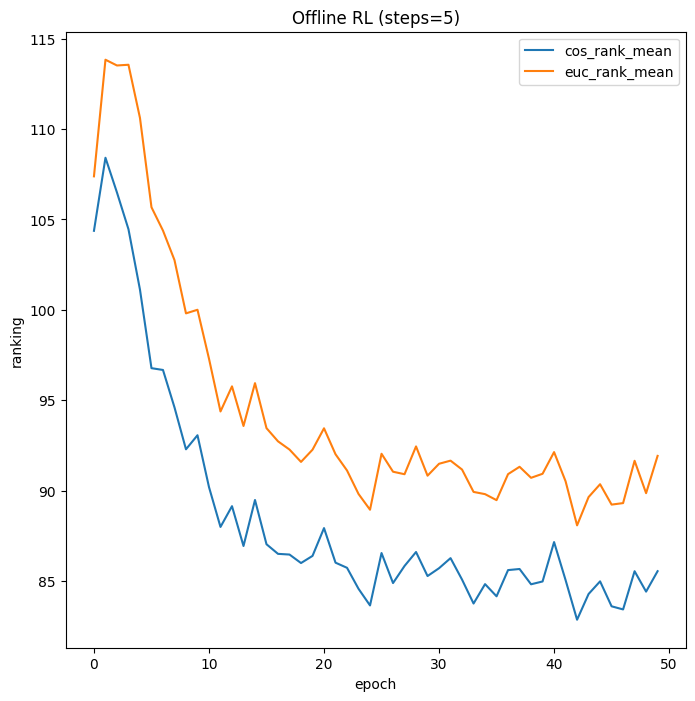

In [9]:
actor_lr = 3e-4
critic_lr = 1e-3
epochs = 50
batch_size = 128
distance_metric, topk, emb_model_update = "euclidean", 10, 1


# Model inits
model = ActorCritic().to(device)
actor_optimizer = torch.optim.Adam(model.parameters(), lr=actor_lr)  
critic_optimizer = torch.optim.Adam(model.parameters(), lr=critic_lr)  
critic_loss_criterion = nn.MSELoss()

# For actor log prob calc
actor_log_std = nn.Parameter(torch.zeros(model.actor.last_layer.out_features, dtype=torch.float32)).to(device)

# Embeddings init
embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
embedding_model.load_state_dict(model.GIN.state_dict())
action_embeddings = get_action_dataset_embeddings(embedding_model)
action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

# Some helper inits
best_rank = 10000
best_model = None
metric_dict = {"cos_rank_mean": [], "euc_rank_mean": [], "cos_rank_std": [], "euc_rank_std": [], 
               "cos_rank_tot": [], "euc_rank_tot": [], "rmse": [], "cos_sim": [], "time(epoch_start-now)": []}

# Train the model
for epoch in range(1, epochs+1):
    start_time = time.time()
    model.train()
    for i in range(0, train_reactants.batch_size - batch_size, batch_size):
        # Forward pass
        actor_actions, critic_qs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])

        # Calc negatives
        negative_indices = []

        for _i in range(actor_actions.shape[0]):
            correct_action_dataset_index = correct_action_dataset_indices[train_idx[i+_i]]
            curr_out = actor_actions[_i].detach()
            dist = torch.linalg.norm(action_embeddings - curr_out, axis=1)
            sorted_idx = torch.argsort(dist)[:topk] # get topk
            sorted_idx = sorted_idx[sorted_idx != correct_action_dataset_index] # Remove if correct index in list
            negative_indices.append(sorted_idx)

        # critic update
        batch_reactants = train_reactants[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(actor_actions.shape[0])], [])]
        batch_products = train_products[sum([[i+_i]*(1+negative_indices[_i].shape[0]) for _i in range(actor_actions.shape[0])], [])]
        batch_rsigs = action_rsigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(actor_actions.shape[0])], [])]
        batch_psigs = action_psigs[sum([[correct_action_dataset_indices[train_idx[i+_i]]] + negative_indices[_i].tolist() for _i in range(actor_actions.shape[0])], [])]
        batch_q_targets = torch.Tensor(sum([[1] + [0] * negative_indices[_i].shape[0] for _i in range(actor_actions.shape[0])], [])).view(-1, 1)


        critic_qs = model(batch_reactants.to(device), batch_products.to(device), batch_rsigs.to(device), batch_psigs.to(device), "critic")
        critic_loss = critic_loss_criterion(critic_qs, batch_q_targets.to(device))
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        # actor update
        actor_actions = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size], train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size], "actor")
        normal_dist = torch.distributions.Normal(actor_actions, actor_log_std.exp())
        positives = get_action_embedding_from_packed_molecule(embedding_model, train_rsigs[i:i+batch_size], train_psigs[i:i+batch_size])
        positive_log_pi = normal_dist.log_prob(positives)
        negative_log_pi = []
        for _i, _indices in enumerate(negative_indices):
            normal_dist = torch.distributions.Normal(actor_actions[_i], actor_log_std.exp())
            negative_log_pi.append(normal_dist.log_prob(action_embeddings[_indices]))
        negative_log_pi = torch.concatenate(negative_log_pi, axis=0)
        
        actor_loss = torch.concatenate([-positive_log_pi, (1/(topk*2))*negative_log_pi], axis=0).sum(-1, keepdim=True).mean() # Using R = 1 for positives, and R = -0.1 for negatives 
        
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        # Emptry any cache (free GPU memory)
        torch.cuda.empty_cache()

    print (f'Epoch {epoch}/{epochs}. Batch {i}/{train_reactants.batch_size - batch_size}. Actor loss = {actor_loss.item():.6f} || critic loss = {critic_loss.item():.6f}')#, end='\r')

    # SWITCH INDENT HERE ----
    model.eval()
    with torch.no_grad():
        print()

        margin_string = f"# emb_model_update = {emb_model_update} | dist_metric = {distance_metric} | topk = {topk} #"
        print("#" * len(margin_string))
        print(margin_string)
        print("#" * len(margin_string))

        # Predictions and action component-wise loss
        pred = torch.concatenate([model(test_reactants[i:i+batch_size], test_products[i:i+batch_size], test_rsigs[i:i+batch_size], test_psigs[i:i+batch_size])[0].detach() for i in range(0, test_reactants.batch_size-batch_size, batch_size)], axis=0)
        true = get_action_embedding_from_packed_molecule(embedding_model, test_rsigs[:pred.shape[0]], test_psigs[:pred.shape[0]]) #get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

        metric_df = pd.DataFrame(columns=["rmse", "cos_sim", "euc_rank_mean", "euc_rank_std", "euc_rank_tot", "cos_rank_mean", "cos_rank_std", "cos_rank_tot", "time(epoch_start-now)"])

        # Print Test metrics
        metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean().item() )
        metric_dict["cos_sim"].append( ((pred*true).sum(axis=1) / torch.linalg.norm(pred, axis=1) / torch.linalg.norm(true, axis=1)).mean().item() )

        # Print Test metric - Rank
        for dist in ["euclidean", "cosine"]:
            rank_list = []
            l = []
            total = []
            for i in range(pred.shape[0]):
                pred_for_i = pred[i]
                act_emb_for_i, correct_applicable_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_applicable_indices[test_idx[i]]

                rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_applicable_index, distance=dist)
                l.append(rank.item())
                total.append(act_emb_for_i.shape[0])
            rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
            metric_dict[f"{dist[:3]}_rank_mean"].append(np.mean(l))
            metric_dict[f"{dist[:3]}_rank_std"].append(np.std(l))
            metric_dict[f"{dist[:3]}_rank_tot"].append(np.mean(total))

        metric_dict["time(epoch_start-now)"].append(f"{(time.time()-start_time)/60:.2f} min")
        for col in metric_df.columns:
            metric_df[col] = [metric_dict[col][-1]]
        metric_df.index = [epoch]
        print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
        print()

    # Update embedding model and action_embeddings
    if epoch % emb_model_update == 0:
        embedding_model.load_state_dict(model.GIN.state_dict())
        action_embeddings = get_action_dataset_embeddings(embedding_model)
        action_embeddings_norm = torch.linalg.norm(action_embeddings, axis=1)

    # Update best model
    if metric_dict["euc_rank_mean"][-1] < best_rank:
        best_rank = metric_dict["euc_rank_mean"][-1]
        best_model = type(model)()
        best_model.load_state_dict(model.state_dict())
        best_epoch = epoch
        print(f"BEST MODEL UPDATED! BEST RANK = {best_rank}")

fig = plt.figure(figsize=(8, 8))
for dist in filter(lambda x: "mean" in x, metric_dict.keys()):
    plt.plot(metric_dict[dist], label=dist)
plt.title(f"Offline RL (steps={steps})")
plt.xlabel("epoch")
plt.ylabel("ranking")
plt.legend()
fig.show()

# save everything
folder = f"models/supervised/offlineRL/emb_model_update={emb_model_update}||steps={steps}||topk={topk}"
os.makedirs(folder, exist_ok = True)
torch.save(model, os.path.join(folder, "model.pth"))
pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
fig.savefig(os.path.join(folder, "plot.png"))
json.dump({
    "steps(trajectory length)": steps,
    "actor_lr": actor_lr,
    "critic_lr": critic_lr,
    "epochs": epochs, 
    "batch_size": batch_size,
    "train_samples": train_idx.shape,
    "test_samples": test_idx.shape,
    "distance_metric": distance_metric,
    "topk": topk,
    "emb_model_update": emb_model_update,
    "best_epoch": best_epoch,
    "best_rank": best_rank
}, open(os.path.join(folder, "config.txt"), 'w'))
print("Saved model at", folder)